In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import nltk
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from scipy.sparse import vstack
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from wordcloud import WordCloud

warnings.filterwarnings("ignore")


In [4]:
# Load Dataset
def load_data(file_path):
    dataset = pd.read_csv(file_path, encoding='latin-1', header=None)
    dataset.columns = ['target', 'id', 'date', 'flag', 'user', 'text']
    print(f"Dataset shape: {dataset.shape}")
    return dataset

data = load_data('training.1600000.processed.noemoticon.csv')


Dataset shape: (1600000, 6)


In [5]:
# Split Dataset into Train and Test
def split_dataset(df, train_ratio=0.8):
    train_size = int(len(df) * train_ratio)
    train_df = df[:train_size]
    test_df = df[train_size:]
    print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")
    return train_df, test_df

train, test = split_dataset(data)

Train shape: (1280000, 6), Test shape: (320000, 6)


In [6]:
# Display dataset info
def explore_data(df):
    print(df.info())
    print(df.describe())
    print("\nMissing Values:")
    print(df.isnull().sum())
    return df.head()

print("Train Data Preview:")
print(explore_data(train))
print("\nTest Data Preview:")
print(explore_data(test))



Train Data Preview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280000 entries, 0 to 1279999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1280000 non-null  int64 
 1   id      1280000 non-null  int64 
 2   date    1280000 non-null  object
 3   flag    1280000 non-null  object
 4   user    1280000 non-null  object
 5   text    1280000 non-null  object
dtypes: int64(2), object(4)
memory usage: 58.6+ MB
None
             target            id
count  1.280000e+06  1.280000e+06
mean   1.500000e+00  1.977036e+09
std    1.936492e+00  2.082881e+08
min    0.000000e+00  1.467810e+09
25%    0.000000e+00  1.835043e+09
50%    0.000000e+00  1.983408e+09
75%    4.000000e+00  2.179093e+09
max    4.000000e+00  2.329206e+09

Missing Values:
target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64
   target          id                          date      flag  \
0       0  1467810369  Mon Apr 06 2

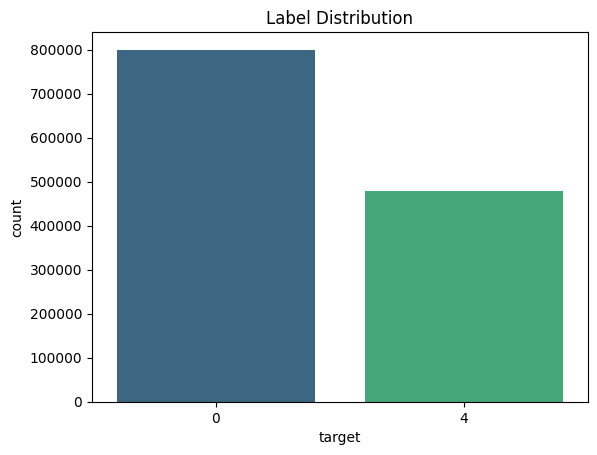

In [7]:
# Visualize Label Distribution
def visualize_labels(df, label_col):
    sns.countplot(x=label_col, data=df, palette='viridis')
    plt.title('Label Distribution')
    plt.show()

visualize_labels(train, 'target')


In [8]:
# Preprocess Text Data
def preprocess_text(df, text_col):
    corpus = []
    for i in range(len(df)):
        if pd.isnull(df[text_col][i]):
            corpus.append("")  # Add empty string for missing values
            continue
        review = re.sub('[^a-zA-Z]', ' ', df[text_col][i])
        review = review.lower()
        review = review.split()
        ps = nltk.stem.PorterStemmer()
        review = [ps.stem(word) for word in review if word not in set(nltk.corpus.stopwords.words('english'))]
        review = ' '.join(review)
        corpus.append(review)
    return corpus

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dhira\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
# Check and handle missing values before preprocessing
train.dropna(subset=['text'], inplace=True)
test.dropna(subset=['text'], inplace=True)

# Reset index to avoid mismatches
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# Preprocess Text Data
train_corpus = preprocess_text(train, 'text')
test_corpus = preprocess_text(test, 'text')

# Validate lengths
assert len(train_corpus) == len(train), "Mismatch between train corpus and train dataframe length"
assert len(test_corpus) == len(test), "Mismatch between test corpus and test dataframe length"

# Add Preprocessed Text Column
train['cleaned_text'] = train_corpus
test['cleaned_text'] = test_corpus


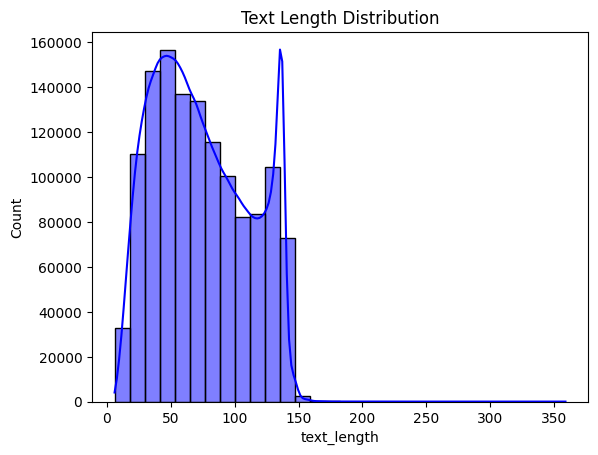

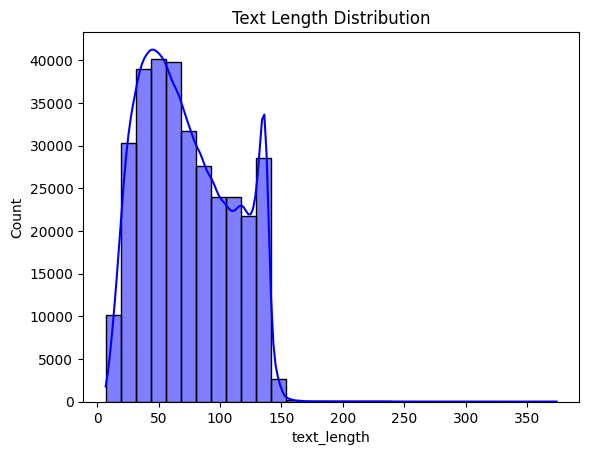

In [10]:
# Feature Engineering
def feature_analysis(df):
    df['text_length'] = df['text'].str.len()
    sns.histplot(df['text_length'], kde=True, color='blue', bins=30)
    plt.title('Text Length Distribution')
    plt.show()
    return df

train = feature_analysis(train)
test = feature_analysis(test)

In [11]:
# Create Bag of Words
def create_bow(corpus, max_features=2500):
    cv = CountVectorizer(max_features=max_features)
    X = cv.fit_transform(corpus)  # Keep as sparse matrix
    return X, cv

X_train, cv = create_bow(train_corpus)
X_test = cv.transform(test_corpus)

In [12]:
# Downcast target variable to save memory
y_train = train['target'].astype('int8')

# Split Train Data for Validation
X_train_split, X_valid, y_train_split, y_valid = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

In [13]:
# Standardization
sc = StandardScaler(with_mean=False)  # Avoid centering to keep sparsity
X_train_split = sc.fit_transform(X_train_split)
X_valid = sc.transform(X_valid)
X_test = sc.transform(X_test)

In [14]:


# Plotting Confusion Matrix Heatmap
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

# Plotting ROC Curve for all models
def plot_roc_curve(all_fpr, all_tpr, aucs):
    plt.figure(figsize=(10, 7))
    
    # Plot the ROC curve for all models
    for i in range(len(all_fpr)):
        plt.plot(all_fpr[i], all_tpr[i], lw=2, label=f'Model {i+1} (AUC = {aucs[i]:.2f})')
    
    # Plot the diagonal (no skill)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for All Models')
    plt.legend(loc='lower right')
    plt.show()

# Model Training and Evaluation
def train_evaluate_model(model, X_train, y_train, X_valid, y_valid, model_id, all_fpr, all_tpr, aucs):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    
    # For binary classification, get the predicted probabilities for the positive class
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_valid)[:, 1]  # Probabilities for the positive class
    else:
        y_pred_prob = y_pred  # If model doesn't support probabilities, fallback to predictions
    
    # Compute ROC curve and AUC for this model
    fpr, tpr, _ = roc_curve(y_valid, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # Append the fpr, tpr, and auc values for plotting later
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    aucs.append(roc_auc)
    
    print(f"Model {model_id} - Training Accuracy: {model.score(X_train, y_train):.2f}")
    print(f"Model {model_id} - Validation Accuracy: {model.score(X_valid, y_valid):.2f}")
    print(f"Model {model_id} - F1 Score: {f1_score(y_valid, y_pred, average='weighted'):.2f}")
    
    cm = confusion_matrix(y_valid, y_pred)
    print(f"Model {model_id} - Confusion Matrix:")
    print(cm)
    
    # Plot Confusion Matrix Heatmap for each model
    plot_confusion_matrix(y_valid, y_pred, labels=[0, 1])  # Adjust the label set as per your binary labels

# Encode labels and update y_train and y_valid to convert '4' to '1'
y_train_split_binary = y_train_split.replace(4, 1)
y_valid_binary = y_valid.replace(4, 1)

# Encode labels (Ensure y_train_split_binary and y_valid_binary have values 0 or 1)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_split_binary)
y_valid_encoded = label_encoder.transform(y_valid_binary)

# Lists to hold ROC data
all_fpr = []
all_tpr = []
aucs = []




Random Forest Classifier:
Model 1 - Training Accuracy: 0.97
Model 1 - Validation Accuracy: 0.76
Model 1 - F1 Score: 0.76
Model 1 - Confusion Matrix:
[[167968  32032]
 [ 44129  75871]]


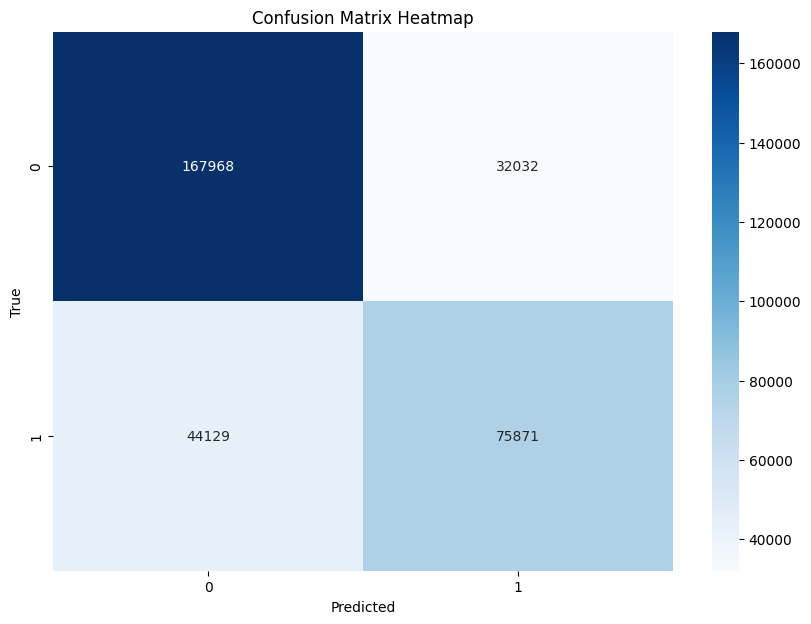

In [15]:
print("\nRandom Forest Classifier:")
train_evaluate_model(RandomForestClassifier(n_jobs=-1), X_train_split, y_train_split_binary, X_valid, y_valid_binary, 1, all_fpr, all_tpr, aucs)




Logistic Regression:
Model 2 - Training Accuracy: 0.78
Model 2 - Validation Accuracy: 0.77
Model 2 - F1 Score: 0.77
Model 2 - Confusion Matrix:
[[171748  28252]
 [ 44254  75746]]


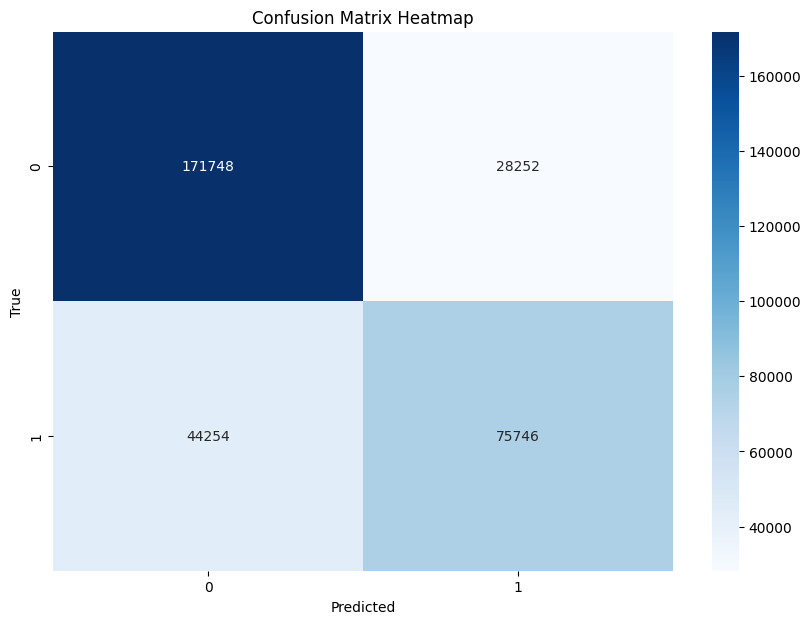

In [16]:
print("\nLogistic Regression:")
train_evaluate_model(LogisticRegression(), X_train_split, y_train_split_binary, X_valid, y_valid_binary, 2, all_fpr, all_tpr, aucs)


Decision Tree Classifier:
Model 3 - Training Accuracy: 0.97
Model 3 - Validation Accuracy: 0.71
Model 3 - F1 Score: 0.71
Model 3 - Confusion Matrix:
[[156751  43249]
 [ 48617  71383]]


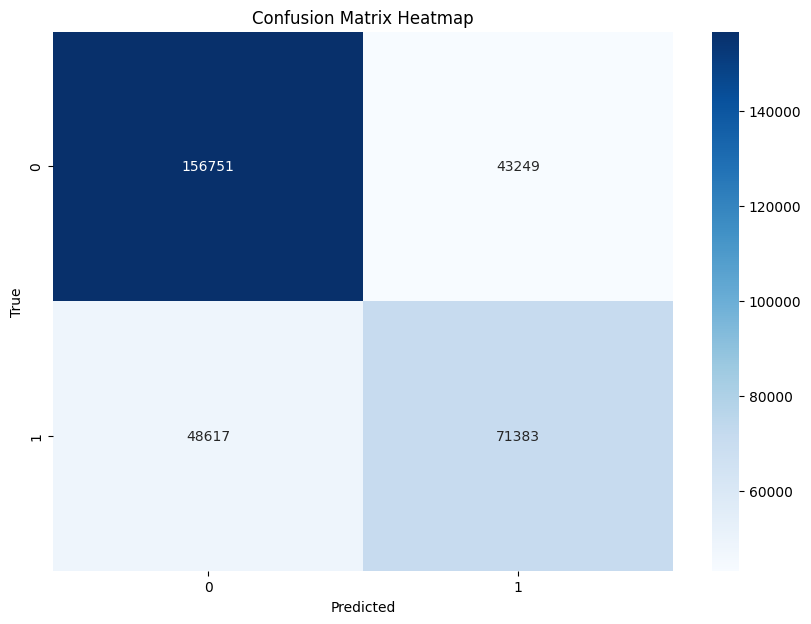

In [17]:
print("\nDecision Tree Classifier:")
train_evaluate_model(DecisionTreeClassifier(), X_train_split, y_train_split_binary, X_valid, y_valid_binary, 3, all_fpr, all_tpr, aucs)



Stochastic Gradient Descent (SGD) Classifier:
Model 4 - Training Accuracy: 0.76
Model 4 - Validation Accuracy: 0.76
Model 4 - F1 Score: 0.76
Model 4 - Confusion Matrix:
[[168771  31229]
 [ 45582  74418]]


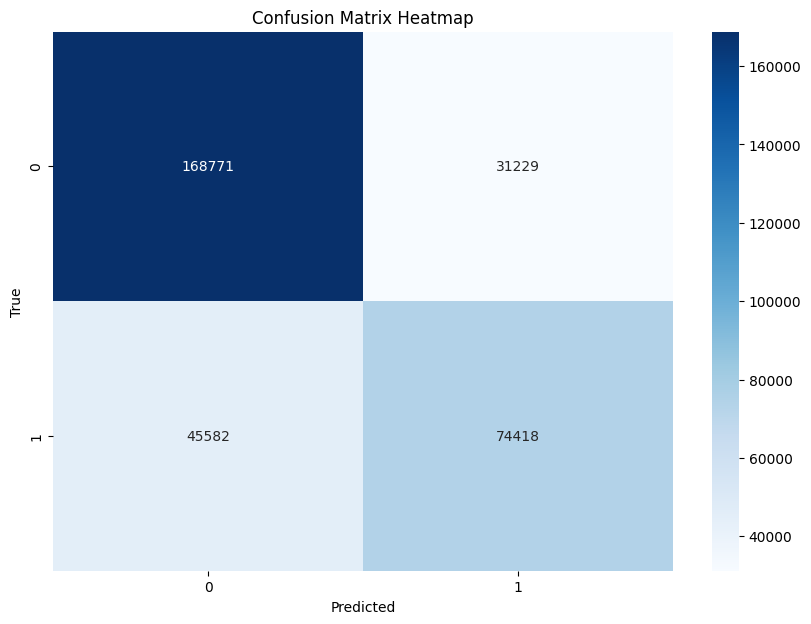

In [18]:
print("\nStochastic Gradient Descent (SGD) Classifier:")
train_evaluate_model(SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3), 
                     X_train_split, y_train_split_binary, X_valid, y_valid_binary, 4, all_fpr, all_tpr, aucs)


XGBoost Classifier:
Model 5 - Training Accuracy: 0.74
Model 5 - Validation Accuracy: 0.74
Model 5 - F1 Score: 0.73
Model 5 - Confusion Matrix:
[[181060  18940]
 [ 63531  56469]]


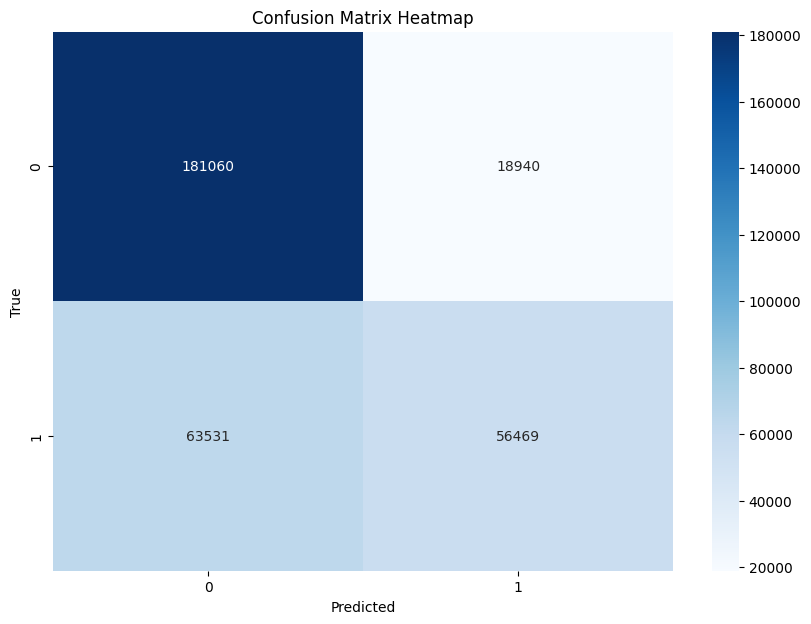

In [19]:
# XGBoost Classifier
print("\nXGBoost Classifier:")
train_evaluate_model(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', tree_method='gpu_hist'),
    X_train_split,
    y_train_split_binary,  # Use binary labels for XGBoost as well
    X_valid,
    y_valid_binary,  # Use binary labels for validation
    5,
    all_fpr,
    all_tpr,
    aucs
)

Number of ROC curves: 5 (Expected: 5)


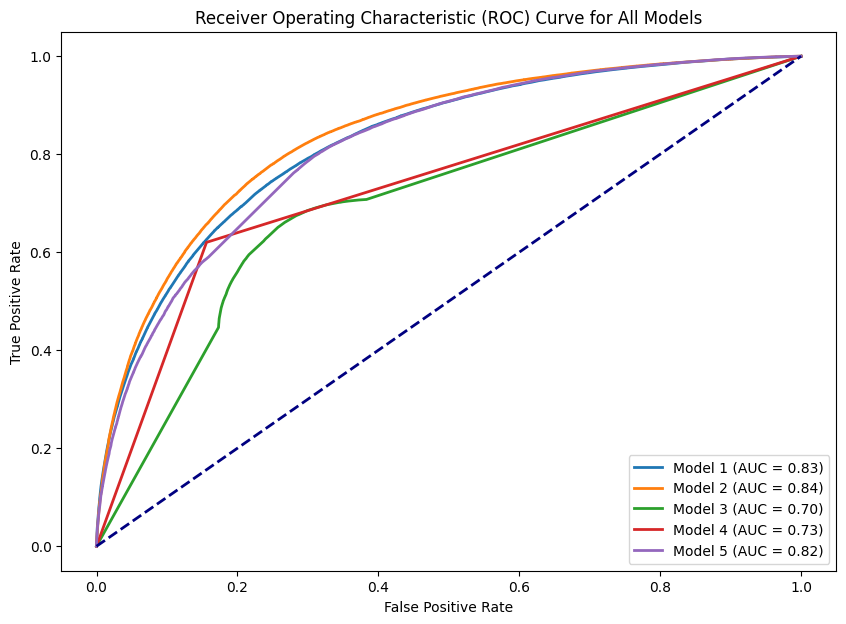

In [20]:
# Validate the number of ROC curves
print(f"Number of ROC curves: {len(all_fpr)} (Expected: 5)")

# After all models are trained and evaluated, plot the ROC curve for all models
plot_roc_curve(all_fpr, all_tpr, aucs)